# Intermediate Scientific Python

This lesson assumes some programming background, but not necessarily with Python. It moves at a faster pace than a novice lesson, however. 

We will learn how to do the following:

1. Reading and manipulating tabular data
2. Visualization and plotting
3. Modularization and documentation
4. Defensive programming
5. Writing command line scripts with Python

This lesson is based heavily on the [Software Carpentry](http://software-carpentry.org/) [``python-intermediate-mosquitoes``](https://github.com/swcarpentry/python-intermediate-mosquitoes) lesson, and uses its datasets. It also includes some mixed-in components from the [``python-novice-inflammation``](https://github.com/swcarpentry/python-novice-inflammation) lesson.

## Getting started

We are interested in understanding the relationship between the weather and the number of mosquitos occuring in a particular year so that we can plan mosquito control measures accordingly. Since we want to apply these mosquito control measures at a number of different sites we need to understand both the relationship at a particular site and whether or not it is consistent across sites. The data we have to address this problem comes from the local government and are stored in tables in comma-separated values (CSV) files. Each file holds the data for a single location, each row holds the information for a single year at that location, and the columns hold the data on both mosquito numbers and the average temperature and rainfall from the beginning of mosquito breeding season. The first few rows of our first file look like:

In [1]:
%cat A1_mosquito_data.csv | head -n 5

year,temperature,rainfall,mosquitos
2001,80,157,150
2002,85,252,217
2003,86,154,153
2004,87,159,158


And we have five files to work with:

In [2]:
%ls *.csv

A1_mosquito_data.csv  A3_mosquito_data.csv  B2_mosquito_data.csv
A2_mosquito_data.csv  B1_mosquito_data.csv


**Note**: commands preceded with a `%` are known as "magics". These are specfic to the notebook environment. They are *not* Python commands.

Since this is tabular data, our tool of choice is [``pandas``](http://pandas.pydata.org/), a library that provides special data structures for doing fast numerical operations on tabular data. Internally, ``pandas`` uses [``numpy``](http://www.numpy.org/) to do the heavy lifting.

In [3]:
import pandas as pd

Importing a library in this way allows us to use the components defined inside of it. First, we'll read in a single dataset using the ``pandas.read_csv`` function:

In [4]:
pd.read_csv('A1_mosquito_data.csv')

,year,temperature,rainfall,mosquitos
0,2001,80,157,150
1,2002,85,252,217
2,2003,86,154,153
3,2004,87,159,158
4,2005,74,292,243
5,2006,75,283,237
6,2007,80,214,190
7,2008,85,197,181
8,2009,74,231,200
9,2010,74,207,184


This reads the CSV from disk and deserializes it into a [``pandas.DataFrame``](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe). But unless we attach a name to the `DataFrame` the function returns, we cannot keep working with the object in memory.

In [5]:
data = pd.read_csv('A1_mosquito_data.csv')

In [6]:
data

,year,temperature,rainfall,mosquitos
0,2001,80,157,150
1,2002,85,252,217
2,2003,86,154,153
3,2004,87,159,158
4,2005,74,292,243
5,2006,75,283,237
6,2007,80,214,190
7,2008,85,197,181
8,2009,74,231,200
9,2010,74,207,184


Now we can refer to the `DataFrame` directly, without having to read it from disk every time.

A bit about names. If I attach the name ``weight_kg`` to the value ``55``:

In [7]:
weight_kg = 55

I can then use this value to calculate the same weight in ``weight_lb``:

In [8]:
weight_lb = 2.2 * weight_kg

In [9]:
weight_lb

121.00000000000001

If I change my `weight_kg` to 66, what is the current value of `weight_lb`?

In [10]:
weight_kg = 66

In [11]:
weight_lb

121.00000000000001

There's no change. This is because the name `weight_lb` is attached to a value, in this case a floating point number. The value has no concept of how it came to be.

In [12]:
weight_lb = 2.2 * weight_kg

In [13]:
weight_lb

145.20000000000002

Back to our `DataFrame`. A `DataFrame` is an **object**. We can see what type of object it is with the Python builtin, ``type``:

In [14]:
type(data)

pandas.core.frame.DataFrame

It turns out that in Python, **everything** is an object. We'll see what this means as we go, but the most important aspect of this is that in Python we have **names**, and we assign these to **objects**. Any name can point to any object, and more than one name can point to a single object.

Anyway, a ``DataFrame`` allows us to get at individual components of our tabular data. We can get single columns like:

In [15]:
data['year']

0    2001
1    2002
2    2003
3    2004
4    2005
5    2006
6    2007
7    2008
8    2009
9    2010
Name: year, dtype: int64

Or multiple columns with:

In [16]:
data[['rainfall', 'temperature']]

,rainfall,temperature
0,157,80
1,252,85
2,154,86
3,159,87
4,292,74
5,283,75
6,214,80
7,197,85
8,231,74
9,207,74


Slicing can be used to get back subsets of rows:

In [17]:
data[0:2]

,year,temperature,rainfall,mosquitos
0,2001,80,157,150
1,2002,85,252,217


Python indices are 0-based, meaning counting goes as 0, 1, 2, 3...; this means that the first row is row 0, the second row is row 1, etc. It's best to refer to row 0 as the "zeroth row" to avoid confusion.

This slice should be read as "get the 0th element up to and not including the 2nd element". The "not including" is important, and the cause of much initial frustration. It does take some getting used to.

What if we want a single row?

In [18]:
data[1]

KeyError: 1

For a DataFrame, this is ambiguous, since a single value is interpreted as a column name. We can only get at rows by slicing at the top level:

In [19]:
data[1:2]

,year,temperature,rainfall,mosquitos
1,2002,85,252,217


Or we could use `.iloc`:

In [20]:
data.iloc[1]

year           2002
temperature      85
rainfall        252
mosquitos       217
Name: 1, dtype: int64

Getting a single row in this way returns a `Series`:

In [21]:
type(data.iloc[1])

pandas.core.series.Series

A `Series` is a 1-D column of values, having all the same datatype. Since each of the datatypes of our columns were integers, we got a `Series` with dtype `int64` this time. If we had columns with, e.g. strings, then we'd get back dtype `object`, which is a catchall for ``pandas``.

We can also get the data in our ``Series`` as a raw ``numpy`` array:

In [22]:
type(data.iloc[1].values)

numpy.ndarray

Pandas is a relatively young library, but it's built on top of the venerable ``numpy`` array, which makes it possible to do fast numerical work in Python. A `Series` is basically a 1-D ``numpy`` array with the ability to select by labeled indices:

## Subsetting data

More usefully than simple slicing, we can use boolean indexing to subselect our data. Say we want only data for years beyond 2005?

In [23]:
data[data['year'] > 2005]

,year,temperature,rainfall,mosquitos
5,2006,75,283,237
6,2007,80,214,190
7,2008,85,197,181
8,2009,74,231,200
9,2010,74,207,184


There's no magic here; we get a boolean index directly from a comparison:

In [24]:
gt_2005 = data['year'] > 2005
gt_2005

0    False
1    False
2    False
3    False
4    False
5     True
6     True
7     True
8     True
9     True
Name: year, dtype: bool

And using this `Series` of bools will then give only the rows for which the `Series` had `True`:

In [25]:
data[gt_2005]

,year,temperature,rainfall,mosquitos
5,2006,75,283,237
6,2007,80,214,190
7,2008,85,197,181
8,2009,74,231,200
9,2010,74,207,184


This is the same behavior as ``numpy`` arrays: using most binary operators, such as ``+``, ``*``, ``>``, ``&``, work element-wise. With a single value on one side (such as ``2005``), we get the result of the operation for each element.

A ``DataFrame`` is an *object*, and objects have **methods**. These are functions that are *part of* the object itself, often doing operations on the object's data. One of these is ``DataFrame.mean``:

In [26]:
data.mean()

year           2005.5
temperature      80.0
rainfall        214.6
mosquitos       191.3
dtype: float64

We get back the mean value of each column as a single ``Series``. There's more like this:

In [27]:
data.max()

year           2010
temperature      87
rainfall        292
mosquitos       243
dtype: int64

There's also ``DataFrame.describe``, which gives common descriptive statistics of the whole `DataFrame`:

In [28]:
data.describe()

,year,temperature,rainfall,mosquitos
count,10.00000,10.000000,10.000000,10.00000
mean,2005.50000,80.000000,214.600000,191.30000
std,3.02765,5.456902,50.317216,33.23335
min,2001.00000,74.000000,154.000000,150.00000
25%,2003.25000,74.250000,168.500000,163.75000
50%,2005.50000,80.000000,210.500000,187.00000
75%,2007.75000,85.000000,246.750000,212.75000
max,2010.00000,87.000000,292.000000,243.00000


This is, itself, a ``DataFrame``:

In [29]:
data.describe()['temperature']

count    10.000000
mean     80.000000
std       5.456902
min      74.000000
25%      74.250000
50%      80.000000
75%      85.000000
max      87.000000
Name: temperature, dtype: float64

Documentation is a key part of Python's design. In the notebook, you can get a quick look at the docs for a given Python function or method with:

In [30]:
data.describe?

Or more generally (built-in Python behavior):

In [31]:
help(data.describe)

Help on method describe in module pandas.core.generic:

describe(percentiles=None, include=None, exclude=None) method of pandas.core.frame.DataFrame instance
    Generate various summary statistics, excluding NaN values.
    
    Parameters
    ----------
    percentiles : array-like, optional
        The percentiles to include in the output. Should all
        be in the interval [0, 1]. By default `percentiles` is
        [.25, .5, .75], returning the 25th, 50th, and 75th percentiles.
    include, exclude : list-like, 'all', or None (default)
        Specify the form of the returned result. Either:
    
        - None to both (default). The result will include only
          numeric-typed columns or, if none are, only categorical columns.
        - A list of dtypes or strings to be included/excluded.
          To select all numeric types use numpy numpy.number. To select
          categorical objects use type object. See also the select_dtypes
          documentation. eg. df.describe(

--------------
### Challenge: obtain the standard deviation of mosquito count for years in which the rainfall was greater than 200:

One way we could do this is to first grab the ``"mosquitos"`` column, then use a fancy index obtained from comparing the ``"rainfall"`` column to ``200``. We can then call the ``std`` method of the resulting ``Series``:

In [32]:
data['mosquitos'][data['rainfall'] > 200].std()

24.587937421969063

Note that this is a key part of the power of ``pandas`` objects: operations for subsetting and calculating descriptive statistics can often be stacked to great effect.

-----------------------

What if we know our temperatures are in fahrenheit, but we want them in celsius? We can convert them.

In [33]:
(data['temperature'] - 32) * 5 / 9

0    26.666667
1    29.444444
2    30.000000
3    30.555556
4    23.333333
5    23.888889
6    26.666667
7    29.444444
8    23.333333
9    23.333333
Name: temperature, dtype: float64

This gives us back a new ``Series`` object. If we want to change the values in our existing ``DataFrame`` to be these, we can just set the column to this new ``Series``:

In [34]:
data['temperature'] = (data['temperature'] - 32) * 5 / 9

In [35]:
data['temperature']

0    26.666667
1    29.444444
2    30.000000
3    30.555556
4    23.333333
5    23.888889
6    26.666667
7    29.444444
8    23.333333
9    23.333333
Name: temperature, dtype: float64

Similarly, it's also possible to add new columns. We could add one giving us, e.g. the ratio of rainfall to mosquitos:

In [36]:
data['rainfall / mosquitos'] = data['rainfall'] / data['mosquitos']

In [37]:
data

,year,temperature,rainfall,mosquitos,rainfall / mosquitos
0,2001,26.666667,157,150,1.046667
1,2002,29.444444,252,217,1.161290
2,2003,30.000000,154,153,1.006536
3,2004,30.555556,159,158,1.006329
4,2005,23.333333,292,243,1.201646
5,2006,23.888889,283,237,1.194093
6,2007,26.666667,214,190,1.126316
7,2008,29.444444,197,181,1.088398
8,2009,23.333333,231,200,1.155000
9,2010,23.333333,207,184,1.125000


It's probably a bit silly to have such a column. So, let's get rid of it:

In [38]:
del data['rainfall / mosquitos']

In [39]:
data

,year,temperature,rainfall,mosquitos
0,2001,26.666667,157,150
1,2002,29.444444,252,217
2,2003,30.000000,154,153
3,2004,30.555556,159,158
4,2005,23.333333,292,243
5,2006,23.888889,283,237
6,2007,26.666667,214,190
7,2008,29.444444,197,181
8,2009,23.333333,231,200
9,2010,23.333333,207,184


Don't like the order of your columns? We can make a ``DataFrame`` with a different column order by selecting them out in the order we want:

In [40]:
data[['rainfall', 'year', 'mosquitos', 'temperature']]

,rainfall,year,mosquitos,temperature
0,157,2001,150,26.666667
1,252,2002,217,29.444444
2,154,2003,153,30.000000
3,159,2004,158,30.555556
4,292,2005,243,23.333333
5,283,2006,237,23.888889
6,214,2007,190,26.666667
7,197,2008,181,29.444444
8,231,2009,200,23.333333
9,207,2010,184,23.333333


We can even have duplicates:

In [41]:
data[['rainfall', 'year', 'mosquitos', 'temperature', 'year']]

,rainfall,year,mosquitos,temperature,year
0,157,2001,150,26.666667,2001
1,252,2002,217,29.444444,2002
2,154,2003,153,30.000000,2003
3,159,2004,158,30.555556,2004
4,292,2005,243,23.333333,2005
5,283,2006,237,23.888889,2006
6,214,2007,190,26.666667,2007
7,197,2008,181,29.444444,2008
8,231,2009,200,23.333333,2009
9,207,2010,184,23.333333,2010


Remember: this returns a copy. It does not change our existing ``DataFrame``:

In [42]:
data

,year,temperature,rainfall,mosquitos
0,2001,26.666667,157,150
1,2002,29.444444,252,217
2,2003,30.000000,154,153
3,2004,30.555556,159,158
4,2005,23.333333,292,243
5,2006,23.888889,283,237
6,2007,26.666667,214,190
7,2008,29.444444,197,181
8,2009,23.333333,231,200
9,2010,23.333333,207,184


## Plotting data from a DataFrame

Just as ``pandas`` is the de-facto library for working with tabular data, ``matplotlib`` is the de-facto library for producing high-quality plots from numerical data. A saying often goes that matplotlib makes easy things easy and hard things possible when it comes to making plots.

In [43]:
import matplotlib.pyplot as plt

We need to tell the notebook to render plots in the notebook itself:

In [44]:
%matplotlib inline

Before we use ``matplotlib`` explicitly, ``pandas`` objects feature convenience methods for common plotting operations. These use ``matplotlib`` internally, so everything we learn later about ``matplotlib`` objects applies to these. For example, we can plot both ``"temperature"`` and ``"mosquitos"`` as a function of ``"year"``:

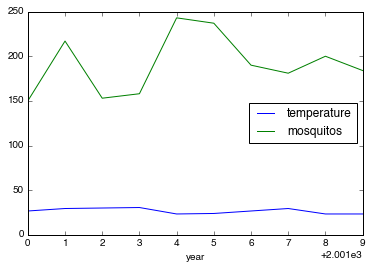

In [45]:
data.plot(x='year', y=['temperature', 'mosquitos'])

Let's load a larger dataset:

In [46]:
data = pd.read_csv('A2_mosquito_data.csv')

This dataset has 51 rows, instead of just 10:

In [47]:
len(data)

51

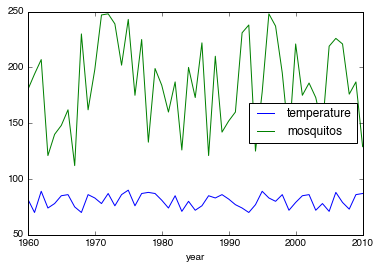

In [48]:
data.plot(x='year', y=['temperature', 'mosquitos'])

There are [other convenience methods](http://pandas.pydata.org/pandas-docs/stable/visualization.html) for different ways of plotting the data. For example, we can get a kernel-density estimate:

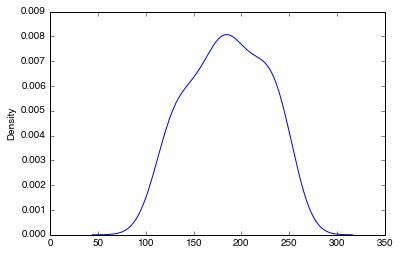

In [49]:
data['mosquitos'].plot.kde()

These convenience methods are great, but for more complex plots we can, and should, use ``matplotlib`` directly. We can make a multi-paneled figure giving both "temperature" and "rainfall" for each "year."

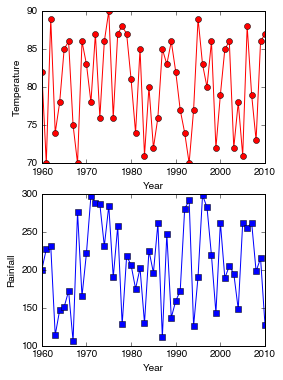

In [50]:
fig = plt.figure(figsize=(4, 6))

ax1 = fig.add_subplot(2, 1, 1)

ax1.plot(data['year'], data['temperature'], 'ro-')

ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature')

ax2 = fig.add_subplot(2, 1, 2)

ax2.plot(data['year'], data['rainfall'], 'bs-')

ax2.set_xlabel('Year')
ax2.set_ylabel('Rainfall')

----------
### Challenge: plot the relationship between the number of mosquitos and temperature and the number of mosquitos and rainfall.

We can do this in a similar way as we did above.

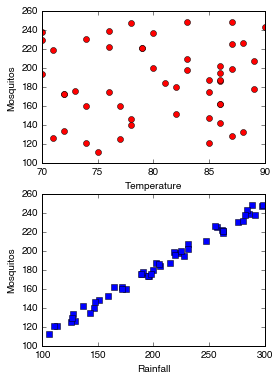

In [51]:
fig = plt.figure(figsize=(4, 6))

ax1 = fig.add_subplot(2, 1, 1)

ax1.plot(data['temperature'], data['mosquitos'], 'ro')

ax1.set_xlabel('Temperature')
ax1.set_ylabel('Mosquitos')

ax2 = fig.add_subplot(2, 1, 2)

ax2.plot(data['rainfall'], data['mosquitos'], 'bs')

ax2.set_xlabel('Rainfall')
ax2.set_ylabel('Mosquitos')

Note that the *linestyle* code on the right can be used to turn off interpolation lines, since we want to just plot the points, and don't care about their order.

-------------

From this one dataset we see what looks like a linear relationship between mosquitos and rainfall, but not really any relationship between mosquitos and temperature. We'd like to quantify this further by applying a statistical model to the data, but we also want to do this same treatment to **all** our datasets. We need to learn a few more things, including **loops**, before continuing further.

## Repetition with loops

Use this lesson: http://nbviewer.jupyter.org/gist/dotsdl/c360b1927323667e3c21#Loops-are-for-looping

## Lists: ordered collections of other objects (even other lists)


Use this lesson:
"http://nbviewer.jupyter.org/gist/dotsdl/c360b1927323667e3c21#Lists:-ordered-collections-of-other-objects-(even-other-lists)"

## Plot all the data

Now that we know how to do loops and use lists in Python, we'll use these to make a plot for each dataset. First, we'll import a module called ``glob``:

In [52]:
import glob

We can use this to grab all the filenames matching a "globbing" pattern:

In [53]:
glob.glob("*.csv")

['A1_mosquito_data.csv',
 'A3_mosquito_data.csv',
 'B2_mosquito_data.csv',
 'A2_mosquito_data.csv',
 'B1_mosquito_data.csv']

"Globbing" is the name of the shell-completion patterns common for shells like ``sh`` and ``bash``.

### Challenge: write a for-loop that produces a plot of mosquito population vs. temperature and mosquito population vs. rainfall for each dataset we have.

We can grab the block of code we wrote previously, and loop through it for each file obtained by globbing:

A1_mosquito_data.csv


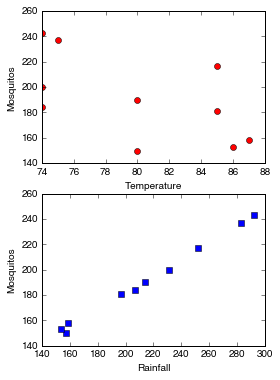

A3_mosquito_data.csv


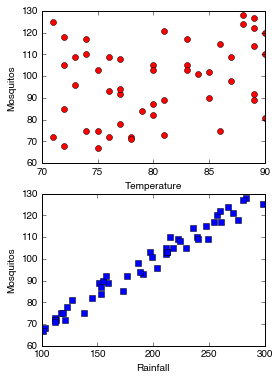

B2_mosquito_data.csv


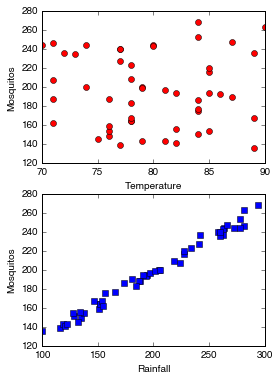

A2_mosquito_data.csv


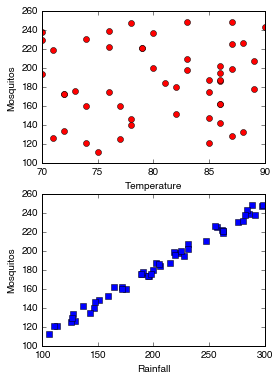

B1_mosquito_data.csv


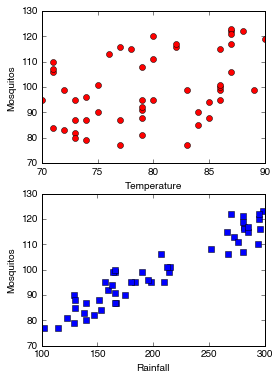

In [54]:
import glob

files = glob.glob('*.csv')

for file in files:
    
    print(file)
    data = pd.read_csv(file)
    
    fig = plt.figure(figsize=(4, 6))

    ax1 = fig.add_subplot(2, 1, 1)

    ax1.plot(data['temperature'], data['mosquitos'], 'ro')

    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Mosquitos')

    ax2 = fig.add_subplot(2, 1, 2)

    ax2.plot(data['rainfall'], data['mosquitos'], 'bs')

    ax2.set_xlabel('Rainfall')
    ax2.set_ylabel('Mosquitos')
    
    # tell matplotlib to render the plot *now*
    plt.show()

It looks like there's a similar pattern for each area we have data for. We'd like to quantify more closely the relationship between mosquito population and each of these variables.

## Applying a statistical model to the dataset

There are many statistics packages in Python, but one of the most well-developed and widely-used is [``statsmodels``](http://statsmodels.sourceforge.net/):

In [55]:
import statsmodels.api as sm

We'll use our second dataset for the initial stab at fitting a statistical model to our data:

In [56]:
data = pd.read_csv('A2_mosquito_data.csv')

And let's convert the temperatures to Celsius, for good measure:

In [57]:
data['temperature'] = (data['temperature'] - 32) * 5 / 9

We can build an ordinary least-squares fit to the data using ``statsmodels.OLS``. Remember we can check the docs with:

In [58]:
sm.OLS?

We want to fit the relationship between mosquito population and, for a start, rainfall:

In [59]:
regr_results = sm.OLS(data['mosquitos'], data['rainfall']).fit()

In [60]:
regr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              mosquitos   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.386e+04
Date:                Mon, 09 May 2016   Prob (F-statistic):           8.69e-63
Time:                        21:38:18   Log-Likelihood:                -196.25
No. Observations:                  51   AIC:                             394.5
Df Residuals:                      50   BIC:                             396.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
rainfall       0.8811      0.007    117.744      0.000         0.866     0.896
==============================================================================
Omnibus:                        4.422   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                1.959
Skew:                          -0.085   Prob(JB):                        0.376
Kurtosis:                       2.055   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So, this gives us a lot of information. But is this what we want? 

We actually want to quantify which variable correlates more with the mosquito population. One way we can build a multivariate model with statsmodels is to use a **formula**:

In [61]:
regr_results = sm.OLS.from_formula('mosquitos ~ temperature + rainfall', data).fit()
regr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              mosquitos   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     7889.
Date:                Mon, 09 May 2016   Prob (F-statistic):           3.68e-61
Time:                        21:38:19   Log-Likelihood:                -111.54
No. Observations:                  51   AIC:                             229.1
Df Residuals:                      48   BIC:                             234.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      17.5457      2.767      6.341      0.000        11.983    23.109
temperature     0.8719      0.092      9.457      0.000         0.687     1.057
rainfall        0.6967      0.006    125.385      0.000         0.686     0.708
==============================================================================
Omnibus:                        1.651   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.438   Jarque-Bera (JB):                0.906
Skew:                          -0.278   Prob(JB):                        0.636
Kurtosis:                       3.343   Cond. No.                     1.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Each of these results can be accessed as **attributes** of the ``Results`` object:

In [62]:
print(regr_results.params)

Intercept      17.545739
temperature     0.871943
rainfall        0.696717
dtype: float64


In [63]:
print(regr_results.rsquared)

0.996966873691


Our model "explains" most of the data. Nice! Let's plot the predicted population of mosquitos from our fitted model against the measured population to see how well we did:

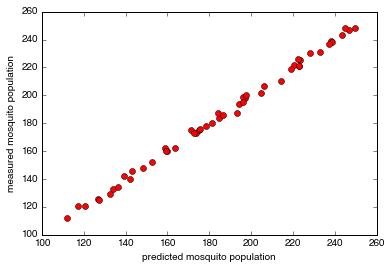

In [64]:
import matplotlib.pyplot as plt

figure = plt.figure()

ax = figure.add_subplot(1,1,1)

parameters = regr_results.params
predicted = parameters['Intercept'] + parameters['temperature'] * data['temperature'] + parameters['rainfall'] * data['rainfall']
ax.plot(predicted, data['mosquitos'], 'ro')

ax.set_xlabel('predicted mosquito population')
ax.set_ylabel('measured mosquito population')

The more linear this plot is, the better our model fits the data. Also, it turns out that, as you might have guessed from the plots we made previously, rainfall is the better predictor than average temperature for how many mosquitoes we expect to see.

In [65]:
regr_results.tvalues

Intercept        6.341405
temperature      9.456614
rainfall       125.385116
dtype: float64

----------------
### Challenge: for each dataset, print the t-value for temperature and rainfall, and plot the statsmodel results along with plots for the relationships between mosquitos and the two variables separately.

We can take our block of code we worked on previously, and make a three-panel plot instead of just a two-panel one:

A1_mosquito_data.csv
Intercept       3.589733
temperature     3.456159
rainfall       56.825601
dtype: float64


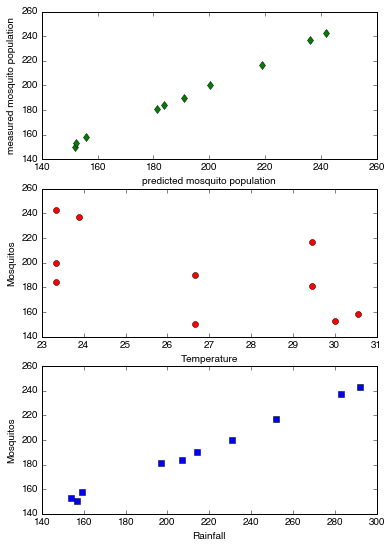

A3_mosquito_data.csv
Intercept       9.658621
temperature    10.881139
rainfall       70.798256
dtype: float64


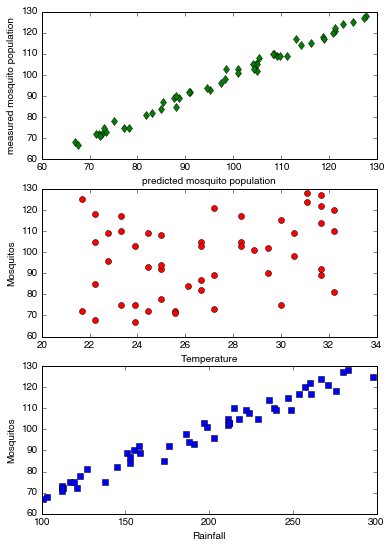

B2_mosquito_data.csv
Intercept        8.778676
temperature     11.647932
rainfall       125.016860
dtype: float64


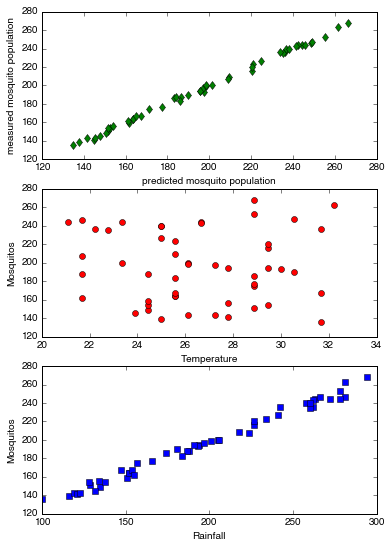

A2_mosquito_data.csv
Intercept        6.341405
temperature      9.456614
rainfall       125.385116
dtype: float64


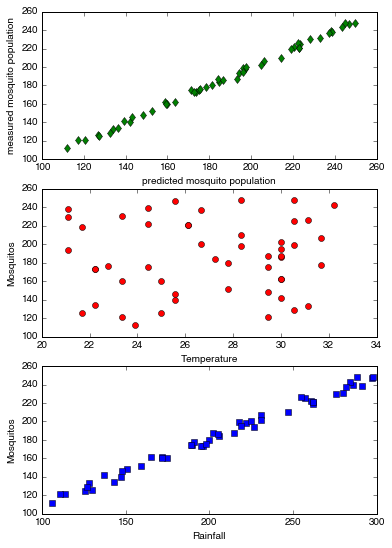

B1_mosquito_data.csv
Intercept      11.016743
temperature    13.396049
rainfall       43.072783
dtype: float64


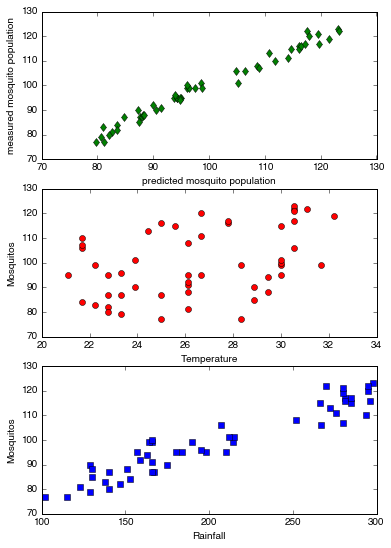

In [66]:
filenames = glob.glob('*.csv')

for filename in filenames:
    print(filename)
    data = pd.read_csv(filename)
    
    # convert temperatures to celsius from fahrenheit
    data['temperature'] = (data['temperature'] - 32) * 5/9
    
    # perform fit
    regr_results = sm.OLS.from_formula('mosquitos ~ temperature + rainfall', data).fit()
    print(regr_results.tvalues)
    
    fig = plt.figure(figsize=(6, 9))

    # plot predicted vs. measured mosquito populations from fitted model
    parameters = regr_results.params
    predicted = parameters['Intercept'] + parameters['temperature'] * data['temperature'] + parameters['rainfall'] * data['rainfall']
    
    ax0 = fig.add_subplot(3, 1, 1)
    ax0.plot(predicted, data['mosquitos'], 'gd')
    
    ax0.set_xlabel('predicted mosquito population')
    ax0.set_ylabel('measured mosquito population')
   
    # plot population vs. temperature
    ax1 = fig.add_subplot(3, 1, 2)

    ax1.plot(data['temperature'], data['mosquitos'], 'ro')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Mosquitos')

    # plot population vs. rainfall
    ax2 = fig.add_subplot(3, 1, 3)

    ax2.plot(data['rainfall'], data['mosquitos'], 'bs')

    ax2.set_xlabel('Rainfall')
    ax2.set_ylabel('Mosquitos')

    plt.show()

For all areas, it looks as if rainfall is indeed the stronger predictor of mosquito population than temperature. But what if this is just the beginning of the number of datasets we have to analyze? Are we going to just copy this block of code around each time we want to analyze new data?

No. That would be awful.

## Writing functions: we need to break things up

We have code blocks we've been copying and pasting around a lot, and this is fine for a while. But once we've built some useful things, we want to re-use them, and we don't want to maintain many versions of the same thing lying around.

In [67]:
def square(x):
    x_squared = x ** 2
    return x_squared

In [68]:
square(3)

9

In [69]:
square(4)

16

Functions are also **composable**:

In [70]:
square(square(3))

81

We can improve on this a bit by adding **documentation**. In Python, we can write a **docstring** for our function directly in its definition:

In [71]:
def square(x):
    """Return the square of the value, `x`.
    
    Parameters
    ----------
    x : float
        Number to obtain the square of.
    
    Returns
    -------
    square : float
        The square of `x`.
    
    """
    x_squared = x ** 2
    return x_squared

And this docstring is now what we see when we use the builtin help system:

In [72]:
help(square)

Help on function square in module __main__:

square(x)
    Return the square of the value, `x`.
    
    Parameters
    ----------
    x : float
        Number to obtain the square of.
    
    Returns
    -------
    square : float
        The square of `x`.



Or alternatively, in the notebook:

In [73]:
square?

---------------
### Challenge: write your fahrenheit to celsius conversion as a function that takes temperatures in fahrenheit and converts them to temperatures in celsius

This is one way we could write it:

In [74]:
def fahrenheit_to_celsius(temp):
    """Convert temperature in fahrenheit to celsius.
    
    Parameters
    ----------
    temp : float or array_like
        Temperature(s) in fahrenheit.
    
    Returns
    -------
    float or array_like
        Temperature(s) in celsius.
    
    """
    return (temp - 32) * 5 / 9

Note that this same function will work for ``pandas.Series`` objects, ``numpy`` arrays, and single numbers. Writing functions in this way takes advantage of the fact that these objects are roughly [**duck-typed**](https://en.wikipedia.org/wiki/Duck_typing): they all behave as if they were single numbers, so doing arithmetic operations with them yields the expected result.

------

----------------
### Challenge: write a function that prints the t-value for temperature and rainfall, and plots the statsmodel results along with plots for the relationships between mosquitos and the two variables separately.

Let's do our model building and plotting in a single function, returning a useful panel plot:

In [75]:
def analyze(data):
    """Return panel plot of mosquito population vs. temperature, rainfall.
    
    Also prints t-values for temperature and rainfall.
    
    Panel plot gives: 
        1. comparison of modeled values of mosquito population vs. actual values
        2. mosquito population vs. average temperature
        3. mosquito population vs. total rainfall
    
    Parameters
    ----------
    data : DataFrame
        DataFrame giving columns for average temperature, 
        total rainfall, and mosquito population during mosquito
        breeding season for each year.
    
    Returns
    -------
    Figure
        :mod:`matplotlib.figure.Figure` object giving panel plot.
    
    """
    # perform fit
    regr_results = sm.OLS.from_formula('mosquitos ~ temperature + rainfall', data).fit()
    print(regr_results.tvalues)
    
    fig = plt.figure(figsize=(6, 9))

    # plot prediction from fitted model against measured mosquito population
    parameters = regr_results.params
    predicted = parameters['Intercept'] + parameters['temperature'] * data['temperature'] + parameters['rainfall'] * data['rainfall']
    
    ax0 = fig.add_subplot(3, 1, 1)
    ax0.plot(predicted, data['mosquitos'], 'go')
    
    ax0.set_xlabel('predicted mosquito population')
    ax0.set_ylabel('measured mosquito population')
   
    # plot population vs. temperature
    ax1 = fig.add_subplot(3, 1, 2)

    ax1.plot(data['temperature'], data['mosquitos'], 'ro')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Mosquitos')

    # plot population vs. rainfall
    ax2 = fig.add_subplot(3, 1, 3)

    ax2.plot(data['rainfall'], data['mosquitos'], 'bs')

    ax2.set_xlabel('Rainfall')
    ax2.set_ylabel('Mosquitos')

    return fig

Note that since this is Python, and everything is an object, we can return our ``Figure`` object. This is generally a useful thing to do for plotting functions, since in different contexts you may want to modify the resulting ``Figure`` before rendering any plots of it.

--------------

We can now re-write our big loop from before, and it should look **a lot** simpler.

A1_mosquito_data.csv
Intercept       3.589733
temperature     3.456159
rainfall       56.825601
dtype: float64


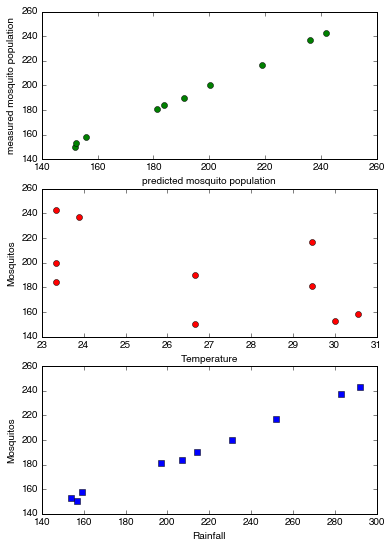

A3_mosquito_data.csv
Intercept       9.658621
temperature    10.881139
rainfall       70.798256
dtype: float64


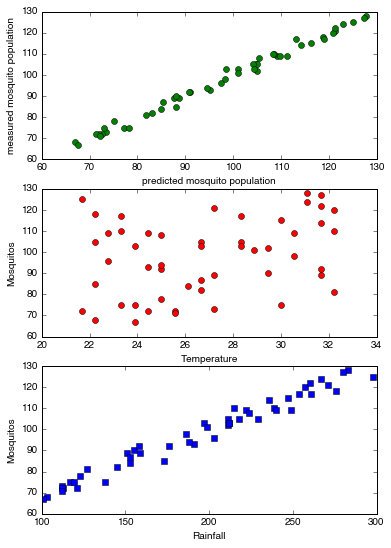

B2_mosquito_data.csv
Intercept        8.778676
temperature     11.647932
rainfall       125.016860
dtype: float64


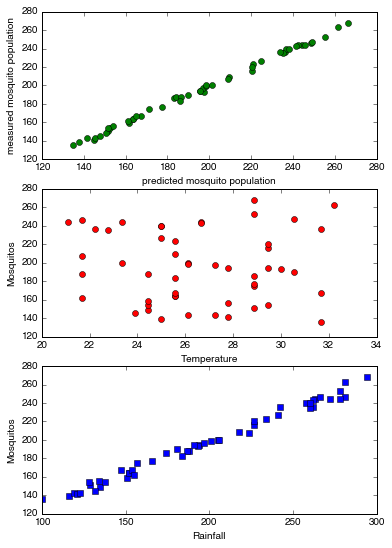

A2_mosquito_data.csv
Intercept        6.341405
temperature      9.456614
rainfall       125.385116
dtype: float64


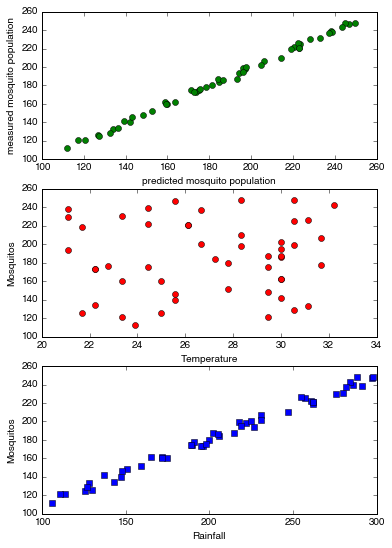

B1_mosquito_data.csv
Intercept      11.016743
temperature    13.396049
rainfall       43.072783
dtype: float64


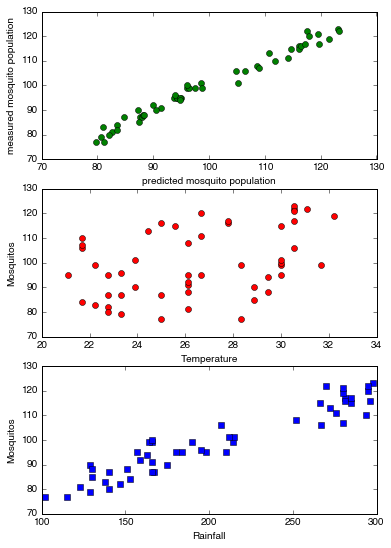

In [76]:
filenames = glob.glob('*.csv')

for filename in filenames:
    print(filename)
    data = pd.read_csv(filename)
    
    # convert temperatures to celsius
    data['temperature'] = fahrenheit_to_celsius(data['temperature'])
    
    # get t-values; return plots
    analyze(data)
    
    plt.show()

Our for loop went from being long and complicated to simple and easy-to-understand. This is part of the power of functions. Because the human brain can only keep about $7 \pm 2$ concepts in working memory at any given time, functions allow us to abstract and build more complicated code without making it more difficult to understand. Instead of having to worry about how filter_data does its thing, we need only know its inputs and its outputs to wield it effectively. It can be re-used without copying and pasting, and we can maintain it and improve it easily since it can be defined in a single place.

Since we may want to use these functions later in other notebooks/code, we can put their definitions in a file and import it. Opening a text editor and copying the function definitions (and the imports they need) to a file datastuff.py, that looks like this:

In [77]:
%cat datastuff.py

import statsmodels.api as sm
import matplotlib.pyplot as plt


def fahrenheit_to_celsius(temp):
    """Convert temperature in fahrenheit to celsius.
    
    Parameters
    ----------
    temp : float or array_like
        Temperature(s) in fahrenheit.
        
    Returns
    -------
    float or array_like
        Temperatures in celsius.

    bubbles
    
    """
    try:
        newtemps = (temp - 32) * 5/9
    except TypeError:
        newtemps = []
        for value in temp:
            newtemps.append(fahrenheit_to_celsius(value))

    return newtemps


def analyze(data):
    """Return panel plot of mosquito population vs. temperature, rainfall.
    
    Also prints t-values for temperature and rainfall.
    
    Panel plot gives: 
        1. comparison of modeled values of mosquito population vs. actual values
        2. mosquito population vs. average temperature
        3. mosquito population vs. total rainfall
    
    Parameters
    ----------
    data : DataFrame
        D

Congratulations: you just made your first Python module! We can import it directly:

In [78]:
import datastuff

And we can see our documentation for these functions and use them as you'd expect:

In [79]:
datastuff.fahrenheit_to_celsius?

Intercept      11.016743
temperature    13.396049
rainfall       43.072783
dtype: float64


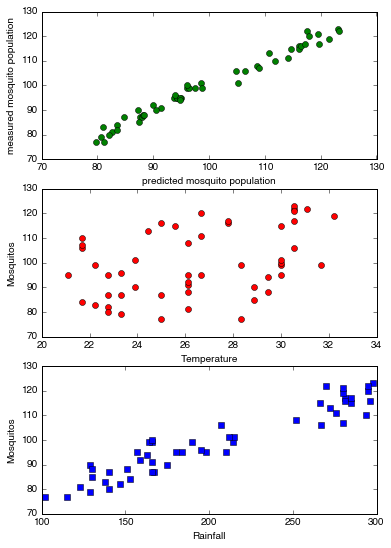

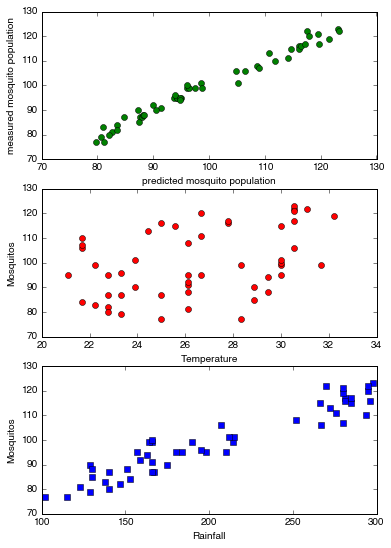

In [80]:
datastuff.analyze(data)

**Note**: if you make modifications to your module, the will not show up in this session, even if you rerun ``import datastuff``. You will either need to restart your Python session, or explicitly tell the Python session to rebuild the module object by re-reading the file:

In [81]:
import importlib

In [82]:
importlib.reload(datastuff)

<module 'datastuff' from '/home/alter/Documents/SWC/Events/2016_UCSF/swc_ucsf_intermediate_data/python/datastuff.py'>

The reason this is the case is because it's more efficient for the Python interpreter to build a module object once from a module file, and then with each import encountered use that same object instead of building a whole new one. It's faster, and requires less memory, for this to be the case.

## An aside: combining DataFrames

Although we didn't need to do it for these examples, ``pandas`` is generally more useful when we can pack as much of our data as is reasonable into a single ``DataFrame``. Since all our datasets have the same form, we can probably gain by combining them.

In [83]:
import pandas as pd
import glob

We will use the ``pandas.concat`` function to make a single ``DataFrame`` from all our others:

In [85]:
filenames = glob.glob('*.csv')
datas = []
keys = []
for filename in filenames:
    keys.append(filename.split('_')[0])
    datas.append(pd.read_csv(filename))
    
df = pd.concat(datas, keys=keys, names=['location'])

We now have a "multi-index" ``DataFrame``:

In [86]:
df

year  temperature  rainfall  mosquitos
location                                           
A1       0   2001           80       157        150
         1   2002           85       252        217
         2   2003           86       154        153
         3   2004           87       159        158
         4   2005           74       292        243
         5   2006           75       283        237
         6   2007           80       214        190
         7   2008           85       197        181
         8   2009           74       231        200
         9   2010           74       207        184
A3       0   1960           76       191         93
         1   1961           73       249        109
         2   1962           81       112         73
         3   1963           78       113         72
         4   1964           81       159         89
         5   1965           87       222        109
         6   1966           72       103         68
         7   1967           77       176         92
         8   1968           89       236        114
         9   1969           88       283        128
         10  1970           89       151         89
         11  1971           71       121         72
         12  1972           88       267        124
         13  1973           85       211        102
         14  1974           75       101         67
         15  1975           72       173         85
         16  1976           74       254        117
         17  1977           85       155         90
         18  1978           89       158         92
         19  1979           86       117         75
...           ...          ...       ...        ...
B1       21  1981           77       115         77
         22  1982           71       267        106
         23  1983           89       164         99
         24  1984           75       175         90
         25  1985           70       210         95
         26  1986           72       214         99
         27  1987           79       123         81
         28  1988           74       195         96
         29  1989           84       129         90
         30  1990           80       276        111
         31  1991           73       147         82
         32  1992           73       140         80
         33  1993           78       285        115
         34  1994           71       280        107
         35  1995           80       180         95
         36  1996           90       280        119
         37  1997           86       166        100
         38  1998           82       285        117
         39  1999           75       215        101
         40  2000           86       212        101
         41  2001           72       138         83
         42  2002           84       130         85
         43  2003           74       166         87
         44  2004           87       280        121
         45  2005           85       130         88
         46  2006           83       102         77
         47  2007           85       163         94
         48  2008           83       190         99
         49  2009           79       151         88
         50  2010           88       295        122

[214 rows x 4 columns]

The outer index gives the area name ("location") the rows came from. These allow us to select rows on the basis of area:

In [87]:
df.loc[('A1', 1)]

year           2002
temperature      85
rainfall        252
mosquitos       217
Name: (A1, 1), dtype: int64

More powerfully, this allows us to get aggregates over all areas:

In [96]:
df[df['year'] > 2005]['temperature'].mean()

81.040000000000006

Or get descriptive statistics directly as a function of location:

In [97]:
df.mean(level='location')

,year,temperature,rainfall,mosquitos
location,,,,
A1,2005.5,80.000000,214.600000,191.300000
A3,1985.0,80.333333,193.274510,97.647059
B2,1985.0,79.764706,196.823529,196.058824
A2,1985.0,80.392157,207.039216,185.235294
B1,1985.0,79.627451,204.588235,99.509804


-------------
### Challenge: obtain the minimum rainfall for each location given that the  temperature was between 75F and 90F.

This is best read backwards. First, let's filter our rows so we only get those for the temperature range we want:

In [98]:
df[(df['temperature'] > 75) & (df['temperature'] < 90)]

year  temperature  rainfall  mosquitos
location                                           
A1       0   2001           80       157        150
         1   2002           85       252        217
         2   2003           86       154        153
         3   2004           87       159        158
         6   2007           80       214        190
         7   2008           85       197        181
A3       0   1960           76       191         93
         2   1962           81       112         73
         3   1963           78       113         72
         4   1964           81       159         89
         5   1965           87       222        109
         7   1967           77       176         92
         8   1968           89       236        114
         9   1969           88       283        128
         10  1970           89       151         89
         12  1972           88       267        124
         13  1973           85       211        102
         17  1977           85       155         90
         18  1978           89       158         92
         19  1979           86       117         75
         21  1981           80       153         87
         23  1983           80       145         82
         27  1987           83       261        117
         28  1988           89       280        127
         29  1989           81       271        121
         30  1990           77       188         94
         31  1991           80       218        105
         33  1993           83       211        105
         34  1994           77       224        108
         36  1996           86       247        115
...           ...          ...       ...        ...
B1       5   1965           76       272        113
         6   1966           77       140         87
         7   1967           87       207        106
         8   1968           86       266        115
         9   1969           79       159         92
         11  1971           79       252        108
         13  1973           82       281        116
         14  1974           80       295        120
         15  1975           86       166         99
         16  1976           87       298        123
         17  1977           79       184         95
         19  1979           86       157         95
         21  1981           77       115         77
         23  1983           89       164         99
         27  1987           79       123         81
         29  1989           84       129         90
         30  1990           80       276        111
         33  1993           78       285        115
         35  1995           80       180         95
         37  1997           86       166        100
         38  1998           82       285        117
         40  2000           86       212        101
         42  2002           84       130         85
         44  2004           87       280        121
         45  2005           85       130         88
         46  2006           83       102         77
         47  2007           85       163         94
         48  2008           83       190         99
         49  2009           79       151         88
         50  2010           88       295        122

[151 rows x 4 columns]

Then, we can grab the minimum rainfall for these:

In [99]:
df[(df['temperature'] > 75) & (df['temperature'] < 90)]['rainfall'].min()

100

But we wanted minimum rainfall **for each location**; we can tell ``Series.min`` to split the data by location:

In [100]:
df[(df['temperature'] > 75) & (df['temperature'] < 90)]['rainfall'].min(level='location')

location
A1    154
A3    112
B2    100
A2    111
B1    102
Name: rainfall, dtype: int64

--------------

We don't have time during this lesson to get into ``groupby``s, but they are such a central part of ``pandas`` that we'd be remiss if we excluded them. A ``groupby`` allows us to split our rows according to values in one or more column. For example, we could ask for the minimum rainfall measured across all areas for each year:

In [102]:
df.groupby('year')['rainfall'].min()

year
1960    129
1961    135
1962    112
1963    113
1964    147
1965    151
1966    103
1967    106
1968    138
1969    147
1970    151
1971    121
1972    153
1973    100
1974    101
1975    134
1976    116
1977    155
1978    128
1979    117
1980    138
1981    115
1982    202
1983    130
1984    151
1985    152
1986    214
1987    111
1988    195
1989    129
1990    159
1991    147
1992    140
1993    211
1994    126
1995    180
1996    187
1997    123
1998    127
1999    123
2000    212
2001    112
2002    130
2003    132
2004    119
2005    130
2006    102
2007    163
2008    186
2009    151
2010    127
Name: rainfall, dtype: int64

This should be read as "group the data by year, then get the minimum rainfall for each group." If we want to do something more complex for each group of rows, we can use a ``for`` loop:

In [104]:
for name, group in df.groupby('year'):
    print(name, group['rainfall'].min())

1960 129
1961 135
1962 112
1963 113
1964 147
1965 151
1966 103
1967 106
1968 138
1969 147
1970 151
1971 121
1972 153
1973 100
1974 101
1975 134
1976 116
1977 155
1978 128
1979 117
1980 138
1981 115
1982 202
1983 130
1984 151
1985 152
1986 214
1987 111
1988 195
1989 129
1990 159
1991 147
1992 140
1993 211
1994 126
1995 180
1996 187
1997 123
1998 127
1999 123
2000 212
2001 112
2002 130
2003 132
2004 119
2005 130
2006 102
2007 163
2008 186
2009 151
2010 127


To learn more about ``groupby``s, check out the ``pandas`` docs on the "split-apply-combine" approach to working with datasets with ``groupby``: http://pandas.pydata.org/pandas-docs/stable/groupby.html

## Conditionals

Use this lesson: http://nbviewer.jupyter.org/gist/dotsdl/c360b1927323667e3c21#Conditionals:-or,-what-do-I-do-now?

-------
### Challenge: rewrite your Fahrenheit to Celsius converter with an if-else statement such that it can also take a list of values in addition to arrays/single numbers.

There are perhaps other ways to do this, but if we want to specifically handle the case of **lists** of temperatures, we can use the builtin ``isinstance`` to check that we are dealing with a list:

In [ ]:
def fahrenheit_to_celsius(temp):
    """Convert temperature in fahrenheit to celsius.
    
    Parameters
    ----------
    temp : float or array_like
        Temperature(s) in fahrenheit.
        
    Returns
    -------
    float or array_like
        Temperatures in celsius.

    bubbles
    
    """
    if isinstance(temp, list):
        newtemps = []
        for value in temp:
            newtemps.append(fahrenheit_to_celsius(value))
    else:
        newtemps = (temp - 32) * 5/9

    return newtemps

This function takes advantage of recursion for the case of a list, calling itself on each value in the list and converting those values accordingly.

## Errors and exceptions

Encountering errors is part of coding. If you are coding, you will hit errors. The important thing to remember is that errors that are loud are the best kind, because they usually give hints as to what the problem is. In Python, errors are known as **exceptions**, and there are a few common varieties. Familiarity with these varieties helps to more quickly identify the root of the problem, which means we can more quickly fix it.

We want to run a function inside a module called ``errors_01.py``; it's inside our ``scripts`` directory:

In [106]:
%ls scripts/

argv_list.py  errors_01.py  plot_rand_mp.py*


Let's try to import it:

In [107]:
import errors_01

ImportError: No module named 'errors_01'

We got an ``ImportError``. This exception tells us that Python cannot find a module we are trying to import. To troubleshoot why, we should first look at ``sys.path``:

In [108]:
import sys
sys.path

['',
 '/home/alter/.local/lib/python3.5/site-packages/scandir-1.1-py3.5-linux-x86_64.egg',
 '/home/alter/Library/datreant/datreant.core/src',
 '/home/alter/Library/datreant/datreant.data/src',
 '/home/alter/Library/asciitree',
 '/usr/lib/python35.zip',
 '/usr/lib/python3.5',
 '/usr/lib/python3.5/plat-linux',
 '/usr/lib/python3.5/lib-dynload',
 '/home/alter/.local/lib/python3.5/site-packages',
 '/usr/lib/python3.5/site-packages',
 '/usr/lib/python3.5/site-packages/gtk-2.0',
 '/home/alter/.local/lib/python3.5/site-packages/IPython/extensions',
 '/home/alter/.ipython']

The Python interpreter looks at each location in this list, in order, when we try to import a module by name. Since our ``scripts`` directory is not in this list, ``errors_01`` is not found. We can add the directory to the list, though, to make ``errors_01`` findable:

In [109]:
sys.path.append('scripts/')

In [111]:
sys.path

['',
 '/home/alter/.local/lib/python3.5/site-packages/scandir-1.1-py3.5-linux-x86_64.egg',
 '/home/alter/Library/datreant/datreant.core/src',
 '/home/alter/Library/datreant/datreant.data/src',
 '/home/alter/Library/asciitree',
 '/usr/lib/python35.zip',
 '/usr/lib/python3.5',
 '/usr/lib/python3.5/plat-linux',
 '/usr/lib/python3.5/lib-dynload',
 '/home/alter/.local/lib/python3.5/site-packages',
 '/usr/lib/python3.5/site-packages',
 '/usr/lib/python3.5/site-packages/gtk-2.0',
 '/home/alter/.local/lib/python3.5/site-packages/IPython/extensions',
 '/home/alter/.ipython',
 'scripts/']

Note that this change will only be present in this session. It is not permanent. This is a perfectly fine method, though, for using a module you've built yourself. Let's import ``errors_01`` now:

In [112]:
import errors_01

SyntaxError: Missing parentheses in call to 'print' (errors_01.py, line 7)

We get a different exception now: a ``SyntaxError``. This the Python interpreter's way of telling us that we are using poor grammar, and it doesn't understand what we are telling it. In this case, it tells us exactly what's wrong:

    SyntaxError: Missing parentheses in call to 'print'
    
If we make the suggested fix in, say, ``errors_02.py`` (we copied the file here for demo purposes, but normally we would fix it and [version control it with git](https://git-scm.com/)):

In [113]:
%cat scripts/errors_02.py

def favorite_ice_cream():
    ice_creams = [
        "chocolate",
        "vanilla",
        "strawberry"
    ]
    print(ice_creams[3])


In [114]:
import errors_02

This one imports just fine. Let's run ``errors_02.favorite_ice_cream``:

In [115]:
errors_02.favorite_ice_cream()

IndexError: list index out of range

This time we get an ``IndexError``. Let's dissect this. The first line shows where the error originates in our code. In this case it's the only line in the cell. The next set of lines shows where the error originates at the source: that is, inside the definition of ``errors_02.favorite_ice_cream`` in line 7 of the module ``errors_02``. The last line gives us a hint as to the nature of the ``IndexError``: we appear to be using an index for an element of a list that doesn't exist.

There are [other types of exceptions](https://docs.python.org/3/library/exceptions.html), but these are some of the most common. You need not know all of them, but having some knowledge of the basic varieties is valuable for understanding what's going wroing, and then how to fix it!

### Aside: catching exceptions

In addition to being useful tools for debugging, exceptions are **catchable**. That is, you can write code in such a way that it is able to recover from failure or exceptional cases. As an example, let's rewrite our Fahrenheit to Celsius converter one last time:

In [116]:
def fahrenheit_to_celsius(temp):
    """Convert temperature in fahrenheit to celsius.
    
    Parameters
    ----------
    temp : float or array_like
        Temperature(s) in fahrenheit.
        
    Returns
    -------
    float or array_like
        Temperatures in celsius.

    bubbles
    
    """
    try:
        newtemps = (temp - 32) * 5/9
    except TypeError:
        newtemps = []
        for value in temp:
            newtemps.append(fahrenheit_to_celsius(value))

    return newtemps

This function can take lists just like the one with the ``if-else`` and ``isinstance`` check, but it turns the problem on its head. It uses a ``try-except`` block instead, first trying to use ``temp`` as a single number or array, and when that fails with a ``TypeError`` (as it would if ``temp`` is a list), it then handles ``temp`` as if it were a list.

This is known as "ask forgiveness" style: we do the most common thing, and if that fails, we then do something else. This is in contrast to "ask permission" style, as exhibited in the ``if-else`` implementation: we first checked if we had a funny case, and if not, did the common thing.

Which you choose is often a matter of style, though there are performance benefits to "ask forgiveness" when the odd cases truly are rare; when the other cases a function must deal with are almost equally common, it is better to use ``if-else`` statements to direct flow.

## Defensive programming: being skeptical of your code

Use this lesson: http://nbviewer.jupyter.org/gist/dotsdl/c360b1927323667e3c21#Defensive-programming:-using-assertions

## Writing Python scripts

Running Python code from a notebook is great, but we often need to run Python code from the command line, perhaps on files as input data. We can turn our module ``datastuff.py`` into a simple script by adding some meat at the bottom:

The ``if __name__ == '__main__'`` statement at the top says that this code should only be executed if the module is being run as a script. It's a common check that the current namespace is `__main__`, as it would only be if the code were being executed as a script.

Adding this allows us to run the script on any number of input files as:

    python datastuff.py A1_mosquito_data.csv A2_mosquito_data.csv
    
or even:

    python datastuff.py *.csv
    
It will loop through each filename given as arguments, convert the temperature column to Celsius, then generate and save a PDF of the analysis figures for that dataset.

``sys.argv`` is a list having the name of the script as its zeroth element, then each argument to the script in order from the first to the last. We do ``sys.argv[1:]`` to slice out only those arguments so we can iterate through them. This is a quick-and-dirty way to parse arguments, but if you're interested in writing more sophisticated command-line utilities, definitely use [``argparse``](https://docs.python.org/3/library/argparse.html).